<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [ ]:
# Installation
!pip install --upgrade mxnet==1.6.0
!pip install gluonts
!pip install yfinance
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install torch
!pip install evaluate
!pip install torchviz
!pip install jupyter-dash
!pip install sns

In [108]:

## Hyper parameters
history = "3y"
buy_trigger = 3             # times standard deviation
sell_trigger = 1            # times the avg cost of the security to grow before we sell
security_age = 15           # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000  # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"           # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5       # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 100    # number of backtests to run


original_balance = 10000    # seed money to start investing
current_account = original_balance
portfolio = {}

In [84]:
import yfinance as yahooFinance
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np

stocks1 = ["AAPL", 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA']
stocks = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA',
          'WMT', 'TSLA', 'PG', 'META', 'MA', 'CVX', 'LLY', 'HD', 'ABBV', 'MRK', 'BAC', 'KO', 
          'PFE', 'PEP', 'AVGO', 'ORCL', 'TMO', 'COST', 'CSCO', 'ABT', 'MCD', 'NKE', 'DHR', 
          'TMUS', 'ACN', 'DIS', 'VZ', 'NEE', 'CMCSA', 'WFC', 'TXN', 'LIN', 'PM', 'UPS', 'ADBE', 
          'BMY', 'SCHW', 'MS', 'CRM', 'COP', 'RTX', 'AMGN', 'NFLX', 'HON', 'T', 'UNP', 'QCOM', 
          'IBM', 'DE', 'CAT', 'LOW', 'BA', 'SBUX', 'INTC', 'SPGI', 'LMT', 'GS', 'CVS', 'BLK', 
          'AXP', 'ELV', 'AMD', 'GILD', 'INTU', 'PLD', 'MDT', 'AMT', 'ADP', 'SYK', 'ISRG', 
          'TJX', 'EL', 'C', 'CB', 'CI', 'MDLZ', 'AMAT', 'PYPL', 'ADI', 'BKNG', 'MMC', 'MO', 'GE', 
          'DUK', 'SLB', 'SO', 'PGR', 'NOW', 'NOC', 'VRTX', 'EOG', 'REGN', 'ZTS', 'TGT', 'MRNA', 'BDX', 
          'MMM', 'HCA', 'USB', 'ITW', 'APD', 'CSX', 'GD', 'PNC', 'BSX', 'CL', 'WM', 'EQIX', 'FISV', 'FCX', 
          'CME', 'ETN', 'CCI', 'AON', 'SHW', 'LRCX', 'MU', 'TFC', 'HUM', 'ATVI', 'ICE', 'KLAC', 'NSC', 
          'CHTR', 'OXY', 'EMR', 'MET', 'PXD', 'MPC', 'MCO', 'MCK', 'DG', 'MNST', 'KHC', 'ORLY', 
          'D', 'VLO', 'SNPS', 'SRE', 'F', 'KDP', 'AEP', 'GIS', 'PSA', 'MAR', 'PSX', 'ROP', 'FDX', 'EW', 
          'ADM', 'APH', 'AIG', 'JCI', 'HSY', 'A', 'KMB', 'AZO', 'CTAS', 'CDNS', 'TRV', 'AFL', 'HES', 'CTVA', 
          'MSI', 'EXC', 'ECL', 'CNC', 'NXPI', 'DXCM', 'PAYX', 'NEM', 'KMI', 'ADSK', 'TT', 'MCHP', 'DVN', 
          'ROST', 'LVS', 'FIS', 'AJG', 'STZ', 'BIIB', 'SYY', 'CMG', 'O', 'RSG', 'IQV', 'PH', 'XEL', 'DOW', 
          'SPG', 'WMB', 'TEL', 'MSCI', 'IDXX', 'BK', 'NUE', 'LHX', 'FTNT', 'COF', 'ALL', 'HAL', 'PRU', 'CARR', 
          'DD', 'TDG', 'YUM', 'ANET', 'HLT', 'PCAR', 'CMI', 'ED', 'ABC', 'EA', 'AMP', 'OTIS', 'WELL', 'MTD', 
          'ODFL', 'SBAC', 'KR', 'AME', 'DLTR', 'VICI', 'DHI', 'ROK', 'WBA', 'KEYS', 'PEG', 'PCG', 'CSGP', 
          'CTSH', 'ENPH', 'RMD', 'OKE', 'WEC', 'BKR', 'NDAQ', 'WBD', 'ILMN', 'PPG', 'GLW', 'STT', 'LYB', 
          'ES', 'IFF', 'DLR', 'AWK', 'VRSK', 'DFS', 'HPQ', 'GWW', 'GPN', 'WTW', 'ON', 'FAST', 'LEN', 'CEG', 
          'APTV', 'TROW', 'URI', 'IT', 'ALB', 'CBRE', 'ZBH', 'EIX', 'MTB', 'CDW', 'ULTA', 'EFX', 'HRL', 'FANG', 
          'TSCO', 'EBAY', 'DAL', 'FE', 'VMC', 'HIG', 'ARE', 'K', 'RJF', 'GPC', 'TSN', 'FITB', 'WY', 'FTV', 
          'ACGL', 'DTE', 'BAX', 'AEE', 'IR', 'AVB', 'FRC', 'MKC', 'VRSN', 'PPL', 'EQR', 'ETR', 'HPE', 'LH', 
          'ANSS', 'LUV', 'PFG', 'MLM', 'HBAN', 'XYL', 'RF', 'CAH', 'WAT', 'CFG', 'STE', 'PWR', 'CHD', 'HOLX', 
          'CTRA', 'NTRS', 'VTR', 'EXR', 'DOV', 'CAG', 'CNP', 'WRB', 'TDY', 'GRMN', 'CMS', 'EPAM', 'STLD', 'BBY', 
          'WST', 'WAB', 'DRI', 'FSLR', 'INVH', 'MPWR', 'AES', 'JBHT', 'ALGN', 'AMCR', 'ROL', 'PAYC', 'MAA', 'IEX', 
          'INCY', 'TTWO', 'BALL', 'OMC', 'CLX', 'DGX', 'CINF', 'EXPD', 'MRO', 'MOH', 'KEY', 'COO', 'BRO', 'TRGP', 
          'SEDG', 'FOX', 'FOXA', 'PKI', 'SJM', 'HWM', 'CPB', 'LYV', 'BR', 'CF', 'FMC', 'J', 'ATO', 'ETSY', 'FDS', 
          'SWKS', 'UAL', 'ZBRA', 'NVR', 'AVY', 'MOS', 'PTC', 'RCL', 'LKQ', 'MGM', 'SYF', 'TXT', 'TER', 
          'EVRG', 'CPRT', 'BEN', 'IRM', 'VTRS', 'EXPE', 'FLT', 'LW', 'GEN', 'PEAK', 'L', 'KIM', 'APA', 'IPG', 
          'ESS', 'NTAP', 'RE', 'NDSN', 'LNT', 'AKAM', 'LDOS', 'IP', 'TYL', 'TRMB', 'SNA', 'UDR', 'PARA', 'JKHY', 
          'CBOE', 'CE', 'BIO', 'POOL', 'MTCH', 'EQT', 'SWK', 'PKG', 'WDC', 'TFX', 'MKTX', 'CPT', 'DPZ', 'CRL', 'GL', 
          'STX', 'HST', 'VFC', 'MAS', 'NWS', 'NWSA', 'NI', 'PHM', 'CHRW', 'WYNN', 'HSIC', 'CCL', 'EMN', 'KMX', 'REG', 
          'BXP', 'UHS', 'BBWI', 'JNPR', 'TPR', 'BWA', 'AAL', 'ALLE', 'QRVO', 'CZR', 'CDAY', 'WRK', 'AOS', 'AAP', 'HII', 
          'HAS', 'IVZ', 'CMA', 'FFIV', 'CTLT', 'PNW', 'WHR', 'FRT', 'RHI', 'PNR', 'DISH', 'SEE', 'RL', 'ZION', 'OGN', 
          'NRG', 'XRAY', 'MHK', 'DVA', 'GNRC', 'AIZ', 'DXC', 'NWL', 'ALK', 'NCLH', 'LUMN', 'LNC', 'VNO', 'TECH', 
          'TAP',] # '^IXIC', '^GSPC', '^DJI']

indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock+"_Diff"] = d['Close'] - d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()
    #latest[stock+"_Diff"] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']
    """
    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock+"_Diff", title=stock + " Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock+"_Diff"])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock+"_Diff", data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();
    """

In [85]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title=stock + " Price change", markers=True)
fig.show()

In [86]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s + "_Diff"] = stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s+"_Diff"] <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s+"_Diff", 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s+"_Diff", 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  
  return latest_diff[latest_diff['sell']], latest_diff[latest_diff['buy']]


In [87]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = 10000
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. volatility
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(portfolio[stock]['shares']):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement

In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  original_balance = 10000
  current_account = original_balance
  portfolio = {}
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

Total networth: 11202 (Cash 300) after going back 284
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 12285 (Cash 2221) after going back 184
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 11148 (Cash 329) after going back 163
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 10379 (Cash 644) after going back 287
{'CRL': {'shares': 5, 'costs': [312.6300048828125, 312.6300048828125, 312.6300048828125, 312.6300048828125, 312.6300048828125], 'date': Timestamp('2022-02-15 00:00:00-0500', tz='America/New_York')}, 'XRAY': {'shares': 5, 'costs': [51.7347412109375, 51.7347412109375, 51.7347412109375, 51.7347412109375, 51.7347412109375], 'date': Timestamp('2022-03-02 00:00:00-0500', tz='America/New_York')}, 'LOW': {'shares': 5, 'costs': [223.0347137451172, 223.0347137451172, 223.0347137451172, 223.0347137451172, 223.0347137451172], 'date': Timestamp('2022-03-21 00:00:00-0400', tz='America/New_York')}, 'GOOG': {'shares': 5, 'costs': [124.9375, 124.9375, 124.9375, 124.9375, 124.9375], 'date': Timestamp('2022-04-21 00:00:00-0400', tz='America/New_York')}, 'CHD': {'shares': 5, 'costs': [87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156], 'date': Timestamp('2022-07-29 00:00:00-0400', tz='America/New_York')}, 'SY

Total networth: 10822 (Cash 578) after going back 265
{'ABBV': {'shares': 5, 'costs': [163.60243225097656, 163.60243225097656, 163.60243225097656, 163.60243225097656, 163.60243225097656], 'date': Timestamp('2022-04-11 00:00:00-0400', tz='America/New_York')}, 'GOOGL': {'shares': 10, 'costs': [124.81449890136719, 124.81449890136719, 124.81449890136719, 124.81449890136719, 124.81449890136719, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062], 'date': Timestamp('2022-04-21 00:00:00-0400', tz='America/New_York')}, 'HPQ': {'shares': 10, 'costs': [36.93316650390625, 36.93316650390625, 36.93316650390625, 36.93316650390625, 36.93316650390625, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date':

Total networth: 11125 (Cash 630) after going back 197
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 11053 (Cash 2141) after going back 263
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'shares': 5, 'costs': [257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594], 'date': Timestamp('2023-02-17 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:0

Total networth: 12143 (Cash 19) after going back 201
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': 

Total networth: 12191 (Cash 610) after going back 124
{'ABC': {'shares': 5, 'costs': [160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094], 'date': Timestamp('2023-02-01 00:00:00-0500', tz='America/New_York')}, 'MCK': {'shares': 5, 'costs': [365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125], 'date': Timestamp('2023-02-02 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'

Total networth: 12482 (Cash 531) after going back 214
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 11118 (Cash 326) after going back 250
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11413 (Cash 43) after going back 269
{'MCK': {'shares': 5, 'costs': [365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125], 'date': Timestamp('2023-02-02 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares':

Total networth: 12150 (Cash 26) after going back 187
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': 

Total networth: 11022 (Cash 10093) after going back 262
{'CDW': {'shares': 5, 'costs': [185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875], 'date': Timestamp('2023-03-28 00:00:00-0400', tz='America/New_York')}}


Total networth: 12408 (Cash 2768) after going back 241
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 12374 (Cash 2733) after going back 177
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 10921 (Cash 451) after going back 107
{'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DG': {'shares': 5, 'costs': [241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'

Total networth: 12423 (Cash 2691) after going back 199
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 12249 (Cash 1762) after going back 206
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'s

Total networth: 12249 (Cash 387) after going back 127
{'ALL': {'shares': 5, 'costs': [134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562], 'date': Timestamp('2023-01-17 00:00:00-0500', tz='America/New_York')}, 'PG': {'shares': 5, 'costs': [145.49700927734375, 145.49700927734375, 145.49700927734375, 145.49700927734375, 145.49700927734375], 'date': Timestamp('2023-01-18 00:00:00-0500', tz='America/New_York')}, 'TMO': {'shares': 5, 'costs': [580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438], 'date': Timestamp('2023-01-24 00:00:00-0500', tz='America/New_York')}, 'ADP': {'shares': 5, 'costs': [226.72598266601562, 226.72598266601562, 226.72598266601562, 226.72598266601562, 226.72598266601562], 'date': Timestamp('2023-01-25 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, '

Total networth: 12374 (Cash 2733) after going back 177
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 12118 (Cash 449) after going back 202
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 12143 (Cash 19) after going back 201
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': 

Total networth: 12374 (Cash 2734) after going back 198
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 10112 (Cash 923) after going back 294
{'GOOG': {'shares': 20, 'costs': [148.0364990234375, 148.0364990234375, 148.0364990234375, 148.0364990234375, 148.0364990234375, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 138.93800354003906, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 119.61399841308594, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.3000030517578

Total networth: 10832 (Cash 1083) after going back 159
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOGL': {'shares': 5, 'costs': [110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'd

Total networth: 12249 (Cash 1753) after going back 186
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 11118 (Cash 326) after going back 250
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 12143 (Cash 19) after going back 201
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': 

Total networth: 12248 (Cash 657) after going back 194
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 10, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375

Total networth: 11160 (Cash 317) after going back 271
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 10843 (Cash 769) after going back 293
{'NFLX': {'shares': 5, 'costs': [429.4800109863281, 429.4800109863281, 429.4800109863281, 429.4800109863281, 429.4800109863281], 'date': Timestamp('2022-02-02 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [163.60243225097656, 163.60243225097656, 163.60243225097656, 163.60243225097656, 163.60243225097656], 'date': Timestamp('2022-04-11 00:00:00-0400', tz='America/New_York')}, 'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOG': {'shares': 5, 'costs': [111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'MRO': {'shares': 10, 'costs': [31.334924697875977, 31.334924697875977, 31.334924697875977, 31.334924697875977, 31.334924697875977, 27

Total networth: 11138 (Cash 346) after going back 246
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 10700 (Cash 738) after going back 254
{'ACN': {'shares': 5, 'costs': [322.3836975097656, 322.3836975097656, 322.3836975097656, 322.3836975097656, 322.3836975097656], 'date': Timestamp('2022-04-11 00:00:00-0400', tz='America/New_York')}, 'CHD': {'shares': 5, 'costs': [87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156], 'date': Timestamp('2022-07-29 00:00:00-0400', tz='America/New_York')}, 'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOG': {'shares': 5, 'costs': [111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.6177291

Total networth: 11042 (Cash 473) after going back 133
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 11100 (Cash 596) after going back 148
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 13034 (Cash 1952) after going back 221
{'HPQ': {'shares': 5, 'costs': [30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp(

Total networth: 10925 (Cash 225) after going back 289
{'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'CDW': {'shares': 10, 'costs': [204.90562438964844, 204.90562438964844, 204.90562438964844, 204.90562438964844, 204.90562438964844, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875, 185.82000732421875], 'date': Timestamp('2023-02-21 00:00

Total networth: 12249 (Cash 1753) after going back 186
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 11202 (Cash 300) after going back 285
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11024 (Cash 629) after going back 136
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 12285 (Cash 2221) after going back 183
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 11202 (Cash 300) after going back 285
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11125 (Cash 630) after going back 197
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 10700 (Cash 738) after going back 254
{'ACN': {'shares': 5, 'costs': [322.3836975097656, 322.3836975097656, 322.3836975097656, 322.3836975097656, 322.3836975097656], 'date': Timestamp('2022-04-11 00:00:00-0400', tz='America/New_York')}, 'CHD': {'shares': 5, 'costs': [87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156], 'date': Timestamp('2022-07-29 00:00:00-0400', tz='America/New_York')}, 'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOG': {'shares': 5, 'costs': [111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781, 111.30000305175781], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.6177291

Total networth: 11790 (Cash 651) after going back 132
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 12482 (Cash 531) after going back 214
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 11047 (Cash 12) after going back 102
{'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'ALL': {'shares': 5, 'costs': [134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562], 'date': Timestamp('2023-01-17 00:00:00-0500', tz='America/New_York')}, 'TMO': {'shares': 5, 'costs': [580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438], 'date': Timestamp('2023-01-24 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestam

Total networth: 11058 (Cash 663) after going back 174
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 11857 (Cash 1132) after going back 200
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp

Total networth: 11365 (Cash 267) after going back 283
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11115 (Cash 693) after going back 140
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492], 'date': Timestamp('2022-12-05 00:00:00-0

Total networth: 10650 (Cash 11) after going back 152
{'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'shares': 5, 'costs': [335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'

Total networth: 12645 (Cash 189) after going back 131
{'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'CVX': {'shares': 10, 'costs': [177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875], 'date': Timestamp('2023-01-27 00:00:00-0500', tz='America/New_York')}, 'ABC': {'shares': 5, 'costs': [160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094], 'date': Timestamp('2023-02-01 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.698623657

Total networth: 10930 (Cash 460) after going back 108
{'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DG': {'shares': 5, 'costs': [241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'

Total networth: 10987 (Cash 2206) after going back 260
{'HPQ': {'shares': 10, 'costs': [36.93316650390625, 36.93316650390625, 36.93316650390625, 36.93316650390625, 36.93316650390625, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2022-06-08 00:00:00-0400', tz='America/New_York')}, 'CHD': {'shares': 5, 'costs': [87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156, 87.11000061035156], 'date': Timestamp('2022-07-29 00:00:00-0400', tz='America/New_York')}, 'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'MRO': {'shares': 5, 'costs': [31.334924697875977, 31.334924697875977, 31.334924697875977, 31.334924697875977, 31.334924697875977], 'date': Tim

Total networth: 11996 (Cash 442) after going back 112
{'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'shares': 5, 'costs': [257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594], 'date': Timestamp('2023-02-17 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00

Total networth: 11053 (Cash 2141) after going back 263
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'shares': 5, 'costs': [257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594], 'date': Timestamp('2023-02-17 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:0

Total networth: 11202 (Cash 300) after going back 285
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 10158 (Cash 671) after going back 299
{'GOOG': {'shares': 10, 'costs': [148.0364990234375, 148.0364990234375, 148.0364990234375, 148.0364990234375, 148.0364990234375, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266, 95.45999908447266], 'date': Timestamp('2022-02-02 00:00:00-0500', tz='America/New_York')}, 'NFLX': {'shares': 5, 'costs': [429.4800109863281, 429.4800109863281, 429.4800109863281, 429.4800109863281, 429.4800109863281], 'date': Timestamp('2022-02-02 00:00:00-0500', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:0

Total networth: 12185 (Cash 384) after going back 142
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'shares': 5, 'costs': [335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'OXY': {'sha

Total networth: 10650 (Cash 11) after going back 152
{'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'shares': 5, 'costs': [335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'

Total networth: 11160 (Cash 317) after going back 273
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11154 (Cash 311) after going back 297
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11069 (Cash 374) after going back 103
{'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'ALL': {'shares': 5, 'costs': [134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562], 'date': Timestamp('2023-01-17 00:00:00-0500', tz='America/New_York')}, 'TMO': {'shares': 5, 'costs': [580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438], 'date': Timestamp('2023-01-24 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON'

Total networth: 11210 (Cash 267) after going back 226
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 11115 (Cash 693) after going back 140
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492], 'date': Timestamp('2022-12-05 00:00:00-0

Total networth: 12191 (Cash 610) after going back 124
{'ABC': {'shares': 5, 'costs': [160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094], 'date': Timestamp('2023-02-01 00:00:00-0500', tz='America/New_York')}, 'MCK': {'shares': 5, 'costs': [365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125, 365.923095703125], 'date': Timestamp('2023-02-02 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'

Total networth: 11365 (Cash 267) after going back 283
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 11341 (Cash 661) after going back 231
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

Total networth: 12374 (Cash 2733) after going back 178
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 10775 (Cash 1076) after going back 162
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOGL': {'shares': 5, 'costs': [110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'CVX': {'shares': 5, 'costs': [177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953], 'date':

Total networth: 12054 (Cash 1119) after going back 236
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp

Total networth: 11057 (Cash 2144) after going back 264
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'shares': 5, 'costs': [257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594], 'date': Timestamp('2023-02-17 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:0

Total networth: 12085 (Cash 1301) after going back 143
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 13036 (Cash 1954) after going back 223
{'HPQ': {'shares': 5, 'costs': [30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp(

Total networth: 12324 (Cash 1919) after going back 217
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 11176 (Cash 273) after going back 169
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 12324 (Cash 1919) after going back 217
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 11057 (Cash 2144) after going back 264
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'shares': 5, 'costs': [257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594, 257.5286560058594], 'date': Timestamp('2023-02-17 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:0

Total networth: 10964 (Cash 411) after going back 105
{'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DG': {'shares': 5, 'costs': [241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578, 241.0500030517578], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'

Total networth: 12285 (Cash 2221) after going back 182
{'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'shares': 5, 'costs': [293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125, 293.37548828125], 'date': Timestamp('2023-02-21 00:00:00-0500', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00

Total networth: 11530 (Cash 377) after going back 170
{'OXY': {'shares': 10, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:0

Total networth: 10832 (Cash 1083) after going back 154
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOGL': {'shares': 5, 'costs': [110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'HPQ': {'shares': 5, 'costs': [30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172, 30.548931121826172], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'd

Total networth: 10650 (Cash 11) after going back 152
{'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY': {'shares': 5, 'costs': [335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625, 335.010009765625], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'

Total networth: 12786 (Cash 173) after going back 130
{'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'CVX': {'shares': 10, 'costs': [177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875, 156.07000732421875], 'date': Timestamp('2023-01-27 00:00:00-0500', tz='America/New_York')}, 'ABC': {'shares': 5, 'costs': [160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094, 160.55516052246094], 'date': Timestamp('2023-02-01 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.698623657

Total networth: 11017 (Cash 321) after going back 141
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 10, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375

Total networth: 11069 (Cash 374) after going back 103
{'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'ALL': {'shares': 5, 'costs': [134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562], 'date': Timestamp('2023-01-17 00:00:00-0500', tz='America/New_York')}, 'TMO': {'shares': 5, 'costs': [580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438], 'date': Timestamp('2023-01-24 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON'

Total networth: 11138 (Cash 641) after going back 135
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492, 62.31913375854492], 'date': Timestamp('2022-12-05 00:00:00-0

Total networth: 10775 (Cash 1076) after going back 160
{'AAPL': {'shares': 5, 'costs': [163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656, 163.09999084472656], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'GOOGL': {'shares': 5, 'costs': [110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062, 110.33999633789062], 'date': Timestamp('2022-08-26 00:00:00-0400', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Timestamp('2023-01-26 00:00:00-0500', tz='America/New_York')}, 'CVX': {'shares': 5, 'costs': [177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953, 177.8775177001953], 'date':

Total networth: 11292 (Cash 479) after going back 266
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 12198 (Cash 1793) after going back 113
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'HD': {'sh

Total networth: 11100 (Cash 596) after going back 149
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 10740 (Cash 5) after going back 106
{'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023-01-12 00:00:00-0500', tz='America/New_York')}, 'ALL': {'shares': 5, 'costs': [134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562, 134.60342407226562], 'date': Timestamp('2023-01-17 00:00:00-0500', tz='America/New_York')}, 'TMO': {'shares': 5, 'costs': [580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438, 580.3446655273438], 'date': Timestamp('2023-01-24 00:00:00-0500', tz='America/New_York')}, 'ADP': {'shares': 5, 'costs': [226.72598266601562, 226.72598266601562, 226.72598266601562, 226.72598266601562, 226.72598266601562], 'date': Timestamp('2023-01-25 00:00:00-0500', tz='America/New_York')}, 'RJF': {'shares': 5, 'costs': [113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797, 113.37999725341797], 'date': Times

Total networth: 11138 (Cash 346) after going back 247
{'DLTR': {'shares': 10, 'costs': [149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 149.91000366210938, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-02-03 00:00:00-0500', tz='America/New_York')}, 'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Times

Total networth: 12118 (Cash 449) after going back 203
{'AJG': {'shares': 10, 'costs': [192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 192.7637481689453, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656, 187.69862365722656], 'date': Timestamp('2023-02-09 00:00:00-0500', tz='America/New_York')}, 'GILD': {'shares': 5, 'costs': [84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688, 84.87179565429688], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'LLY':

Total networth: 12249 (Cash 1762) after going back 206
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'s

Total networth: 12168 (Cash 671) after going back 229
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 10, 'costs': [66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 66.03279876708984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2022-12-05 00:00:00-0500', tz='America/New_York')}, 'CTVA': {'shares': 10, 'costs': [64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 64.2045669555664, 62.31913375854492, 62.31913375

Total networth: 12175 (Cash 1919) after going back 176
{'MMC': {'shares': 5, 'costs': [167.0, 167.0, 167.0, 167.0, 167.0], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'AON': {'shares': 5, 'costs': [312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625, 312.44000244140625], 'date': Timestamp('2023-02-14 00:00:00-0500', tz='America/New_York')}, 'OXY': {'shares': 5, 'costs': [62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984, 62.717830657958984], 'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York')}, 'HSIC': {'shares': 10, 'costs': [82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 82.81999969482422, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156, 78.36000061035156], 'date': Timestamp('2023-02-16 00:00:00-0500', tz='America/New_York')}, 'ALB': {'s

Total networth: 11042 (Cash 473) after going back 133
{'CF': {'shares': 10, 'costs': [103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 103.16266632080078, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172, 82.61772918701172], 'date': Timestamp('2022-12-01 00:00:00-0500', tz='America/New_York')}, 'UNH': {'shares': 5, 'costs': [536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688, 536.3097534179688], 'date': Timestamp('2022-12-13 00:00:00-0500', tz='America/New_York')}, 'ABBV': {'shares': 5, 'costs': [160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812, 160.13772583007812], 'date': Timestamp('2023-01-09 00:00:00-0500', tz='America/New_York')}, 'DGX': {'shares': 5, 'costs': [147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578, 147.4591827392578], 'date': Timestamp('2023

networth


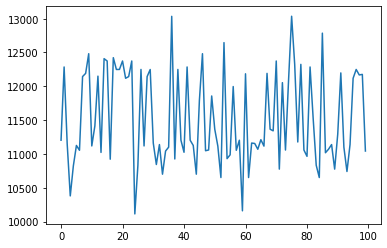

11519.509790182114


In [109]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  print(portfolio)
  nws.append(networth)
  idx_list = list(indices_ts['^GSPC_Close'])[-tradingdays_togoback:]
  d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list})
  d.index = indices_ts.index[-tradingdays_togoback:]
  pm_pct = (pm[-1]-pm[0])*100/pm[0]
  idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
  fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
  fig.show()

print("networth")
plt.plot(nws)

plt.show()
print(sum(nws)/len(nws))

Total networth: 11820 (Cash 4331) after going back 488
{'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 10, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'MS': {'shares': 5, 'costs': [89.97000122070312, 89.97000122070312, 89.97000122070312, 89.97000122070312, 89.97000122070312], 'date': Timestamp('2023-03-14 00:00:00-0400', tz='America/New_York')}, 'RF': {'shares': 10, 'costs': [18.959999084472656, 18.9

Total networth: 12432 (Cash 4076) after going back 550
{'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'CAT': {'shares': 5, 'costs': [246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844], 'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York')}, 'HAL': {'shares': 10, 'costs': [35.56999969482422, 35.56999969482422, 35.56999969482422, 35.56999969482422, 35.56999969482422, 30.

Total networth: 12446 (Cash 4244) after going back 566
{'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'CAT': {'shares': 5, 'costs': [246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844], 'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York')}, 'VICI': {'shares': 5, 'costs': [32.80909729003906, 32.80909729003906, 32.80909729003906, 32.80909729003906, 32.80909729003906], 'd

Total networth: 13836 (Cash 4855) after going back 587
{'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00-0500', tz='America/New_York')}, 'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 10, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75, 101.75], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'FCX': {'shares': 5, 'costs': [40.13999938964844,

Total networth: 11304 (Cash 3123) after going back 542
{'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00-0500', tz='America/New_York')}, 'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'CAT': {'shares': 5, 'costs': [246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844]

Total networth: 11063 (Cash 3929) after going back 554
{'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'FCX': {'shares': 5, 'costs': [40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844], 'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York')}, 'MS': {'shares': 5, 'costs': [89.97000122070312, 89.97000122070312, 89.97000122070312, 89.97000122070312, 89.97000122070312], 'date': T

Total networth: 11152 (Cash 2639) after going back 423
{'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'CAT': {'shares': 5, 'costs': [246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844, 246.13999938964844], 'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York')}, 'HAL': {'shares': 15, 'costs': [35.56999969482422, 35.56999969482422, 35.56999969482422, 35.56999969482422, 35.56999969482422, 30.

Total networth: 12469 (Cash 4532) after going back 461
{'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00-0500', tz='America/New_York')}, 'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'FCX': {'shares': 5, 'costs': [40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844], 'da

Total networth: 10807 (Cash 2961) after going back 466
{'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00-0500', tz='America/New_York')}, 'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'FCX': {'shares': 5, 'costs': [40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844], 'da

Total networth: 10879 (Cash 2959) after going back 402
{'HPQ': {'shares': 5, 'costs': [28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008, 28.594331741333008], 'date': Timestamp('2023-03-01 00:00:00-0500', tz='America/New_York')}, 'HPE': {'shares': 5, 'costs': [15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887, 15.148180961608887], 'date': Timestamp('2023-03-03 00:00:00-0500', tz='America/New_York')}, 'DLTR': {'shares': 5, 'costs': [144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375, 144.05999755859375], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'STLD': {'shares': 5, 'costs': [131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906, 131.97999572753906], 'date': Timestamp('2023-03-06 00:00:00-0500', tz='America/New_York')}, 'FCX': {'shares': 5, 'costs': [40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844, 40.13999938964844], 'da

networth


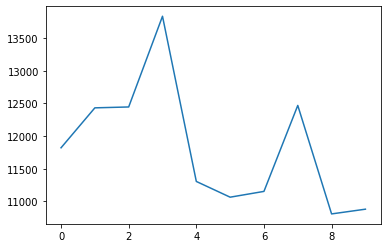

11821.539357662201


In [112]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 30  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(10):
  tradingdays_togoback = random.randint(400, 600)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  print(portfolio)
  nws.append(networth)
  idx_list = list(indices_ts['^GSPC_Close'])[-tradingdays_togoback:]
  d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list})
  d.index = indices_ts.index[-tradingdays_togoback:]
  pm_pct = (pm[-1]-pm[0])*100/pm[0]
  idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
  fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
  fig.show()

print("networth")
plt.plot(nws)

plt.show()
print(sum(nws)/len(nws))